#### Use required libraries

In [1]:
using Compat, Random, Distributions, Plots, LinearAlgebra, CSV, DataFrames, SpecialFunctions, Statistics, NLsolve, Optim, KernelDensity, LaTeXStrings
gr(fmt=:png)
Random.seed!(1);

----
#### Define new functions

In [2]:
function norm_den(x)
    return 1/sqrt(2*π*s^2)*exp(-(x-m)^2/2/s^2)
end

function gap(x, g)
    F = zeros(4)
    a1 = abs(x[1])
    a2 = abs(x[2])
    b = abs(x[3])
    w = min(abs(x[4]),1)
    F[1] = g[1] - (w*a1*(a1+1) + b^2*(1-w)*(a2+1)*a2)/(w*a1 + b*(1-w)*a2)^2
    F[2] = g[2] - (w*a1*(a1+1)*(a1+2)+b^3*(1-w)*(a2+2)*(a2+1)*a2)/(w*a1*(a1+1) + b^2*(1-w)*(a2+1)*a2)/(w*a1 + b*(1-w)*a2)
    F[3] = g[3] - (w*a1*(a1+1)*(a1+2)*(a1+3)+b^4*(1-w)*(a2+3)*(a2+2)*(a2+1)*a2)/(w*a1*(a1+1) + b^2*(1-w)*(a2+1)*a2)^2
    F[4] = g[4] - (w*a1*(a1+1)*(a1+2)*(a1+3)*(a1+4) + b^5*(1-w)*(a2+4)*(a2+3)*(a2+2)*(a2+1)*a2)/(w*a1*(a1+1) + b^2*(1-w)*(a2+1)*a2)/(w*a1*(a1+1)*(a1+2) + b^3*(1-w)*(a2+2)*(a2+1)*a2)
    return sum(F.*F)
end

gap (generic function with 1 method)

----
#### Read the file

<div class="alert alert-block alert-warning">
    <b>Replication Edit:</b> added sink arg for `CSV.read()` for the function to work. The issue can possibly due to different versions of the required libraries.
</div>

In [3]:
df = CSV.read("/app/data/usa1.csv", DataFrame); # Replication edit: needed to add sink arg

----
#### Fill the missing

In [4]:
count, L = 0, size(df,1)
new_prices = zeros(L)
for i in df.id
    count = count + 1
    if count < L
        if isa(df.miss[count+1],Number) & !isa(df.miss[count],Number) & (df.id[count] == df.id[count+1])
            j = count + 1
            while (df.id[j] == df.id[count]) & isa.(df.miss[j],Number)
                j = j + 1
            end
            if (df.id[j] == df.id[count])
                for k in count:1:j
                    if k < (count+j)/2+1
                        new_prices[k] = df.price[count]
                        else
                            new_prices[k] = df.price[j]
                        end
                end     
                else
                    for k in count:1:j-1
                        new_prices[k] = df.price[count]
                    end
                end        
        end
    end
end
new_prices[isa.(df.price,Number)] = df.price[isa.(df.price,Number)];

----
#### Initiate the spells database

In [5]:
spell_price = []
spell_url = []
spell_duration = []
spell_id = []
spell_category = []
spell_sale = []
spell_initial = []
spell_final = []
duration = 0
init = 0
fin = 0

for i in 1:1:L-1
    duration = duration + 1
    if isa(df.initialspell[i],Number)
        init = 1
    end
    if isa(df.lastspell[i],Number)
        fin = 1
    end
    if (df.id[i+1] != df.id[i]) || (new_prices[i+1] != new_prices[i])
        append!(spell_price,new_prices[i])
        append!(spell_id,df.id[i])
        append!(spell_url,df.cat_url[i])
        append!(spell_duration,duration)
        append!(spell_category,df.category[i])
        append!(spell_initial,init)
        append!(spell_final,fin)
        if isa(df.sale[i],Number)
            append!(spell_sale,df.sale[i])
        else
            append!(spell_sale,0)                
        end
        duration = 0
        init = 0
        fin = 0
    end
end

----
#### Write the new dataframe

<div class="alert alert-block alert-info">
    <b>Replication Note:</b> upper_cutoff is denoted in log price changes and lower_cutoff is denoted in dollar price changes.
</div>

In [6]:
dfspells = DataFrame(id = spell_id, url = spell_url, category = spell_category, price = spell_price, duration = spell_duration, initial = spell_initial, final = spell_final, sale = spell_sale)
dfspells.change = zeros(size(dfspells,1))
dfspells.logchange = zeros(size(dfspells,1))
upper_cutoff = 1.5
lower_cutoff = 0.009
remove_sales, remove_short = false, false

# replace the sales, small and large deviations, and short spells with the previous price

flag = [0, 0, 0, 0, 0]
N = length(dfspells.id)
for i in 1:1:N-1
    if (remove_sales) & (dfspells.sale[i+1] == 1)
        dfspells.price[i+1] = dfspells.price[i]
        flag[1] += 1
    end
    if (remove_short) & (dfspells.id[i] == dfspells.id[i+1]) & (dfspells.duration[i+1] < 3)
        dfspells.price[i+1] = dfspells.price[i]
        flag[2] += 1
    end
    if (abs(dfspells.price[i+1] - dfspells.price[i]) < lower_cutoff) & (dfspells.id[i] == dfspells.id[i+1])
        if abs(dfspells.price[i+1] - dfspells.price[i]) > 0
            flag[3] += 1
        end
        dfspells.price[i+1] = dfspells.price[i]
    end
    if (dfspells.id[i] == dfspells.id[i+1]) & (abs(log(dfspells.price[i+1]) - log(dfspells.price[i])) > upper_cutoff)
        dfspells.price[i+1] = dfspells.price[i]
        flag[4] += 1
    end
end
print("Sales deleted: ",flag[1],"\nShort spells deleted: ",flag[2],"\nSmall changes deleted: ",flag[3],"\nLarge changes deleted: ",flag[4])

# merge neighboring spells with the same price and id

for i in 1:1:N-1
    if (abs(dfspells.price[i] - dfspells.price[i+1]) < lower_cutoff) & (dfspells.id[i] == dfspells.id[i+1])
        dfspells.duration[i+1] = dfspells.duration[i+1] + dfspells.duration[i]
        dfspells.initial[i+1] = dfspells.initial[i]
        dfspells.duration[i] = 0
    end
end

# delete zero durations and add changes

dfspells = dfspells[dfspells.duration .> 0, :]
dfspells = dfspells[dfspells.initial.*dfspells.final .== 0, :]
N = length(dfspells.id)
for i in 1:1:N-1
    if dfspells.initial[i+1] == 0
        dfspells.change[i+1] = (dfspells.price[i+1]-dfspells.price[i])/dfspells.price[i]
        dfspells.logchange[i+1] = log(dfspells.price[i+1])-log(dfspells.price[i])
    end
end
select!(dfspells, Not(:sale))
dfspells.length = dfspells.initial - dfspells.final

# go forwards and write the spell number

count = 0
for i in 1:1:N
    count = count + 1
    dfspells.initial[i] = count
    if dfspells.final[i] == 1
        count = 0
    end
end

# go backwards and write the spell length

num = 0
for i in 1:1:N
    if dfspells.final[N+1-i] == 1
        num = dfspells.initial[N+1-i]
    end
    dfspells.length[N+1-i] = num
end

# three products have confcting category identificators, delete them

dfspells = dfspells[dfspells.id .!= 41976, :]
dfspells = dfspells[dfspells.id .!= 46568, :]
dfspells = dfspells[dfspells.id .!= 45549, :];

# write the file with spells

CSV.write("spells1.csv",dfspells);

Sales deleted: 0
Short spells deleted: 0
Small changes deleted: 0
Large changes deleted: 87

----
#### Take products with at least 3 spells (equivalently, at least two changes)

In [7]:
df2 = dfspells[dfspells.length .> 2, :]
S = size(df2[df2.initial .== 3, :],1)
pow41 = (df2[df2.initial .== 2, :].logchange).^4
pow21 = (df2[df2.initial .== 2, :].logchange).^2
pow22 = (df2[df2.initial .== 3, :].logchange).^2;

----
#### Histogram for an exemplary category

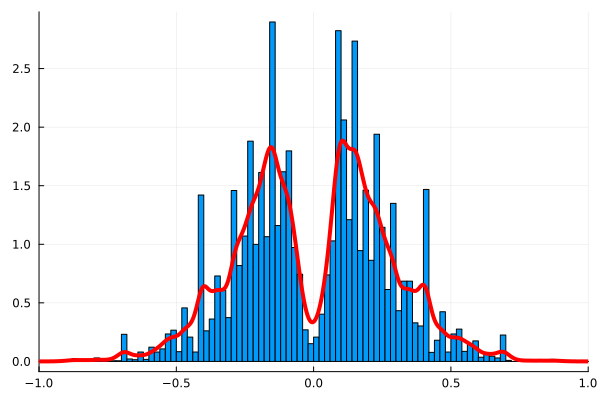

In [8]:
df561 = dfspells[dfspells.category .== 561, :]
density = kde(df561[df561.logchange .!= 0.0, :].logchange,bandwidth=0.03,kernel=Logistic)
histogram(df561[df561.logchange .!= 0.0, :].logchange,xlim=[-1.0,1.0],bins=200,legend=false,normed=true)
plot!(density.x,density.density,color=:red,linewidth=4)

In [9]:
CSV.write("561.csv",df561[df561.logchange .!= 0.0, :])

"561.csv"

----
#### Symmetrized histogram and fitted kernel density

mean absolute price change 0.22689574071501514;
 standard deviation of absolute price change 0.14301799817841288

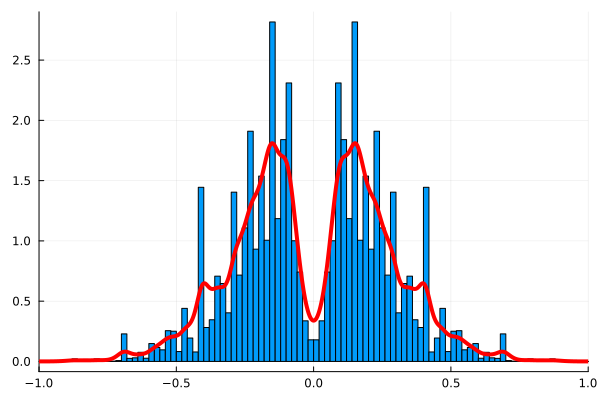

In [10]:
changes = [df561[df561.logchange .!= 0.0, :].logchange; -df561[df561.logchange .!= 0.0, :].logchange]
density = kde(changes,bandwidth=0.03,kernel=Logistic)
kernel_den = DataFrame(x = density.x, q = density.density)
CSV.write("kernel_den.csv",kernel_den)
print("mean absolute price change ",mean(abs.(changes)),";\n standard deviation of absolute price change ",std(abs.(changes)))
histogram(changes,xlim=[-1.0,1.0],normed=true,bins=200,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

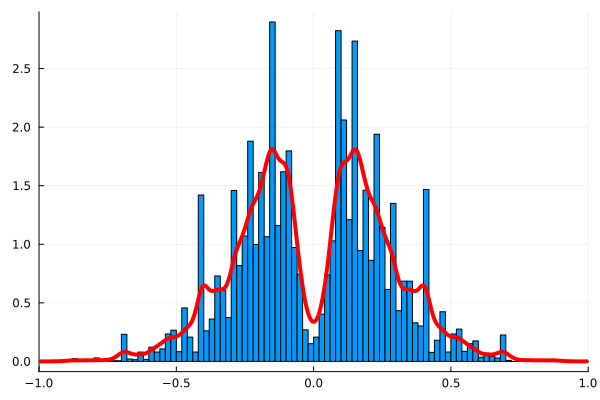

In [11]:
histogram(df561[df561.logchange .!= 0.0, :].logchange,xlim=[-1.0,1.0],bins=200,legend=false,normed=true)
plot!(density.x,density.density,color=:red,linewidth=4)

----
#### Plot $q(0)$ as a function of bandwidth

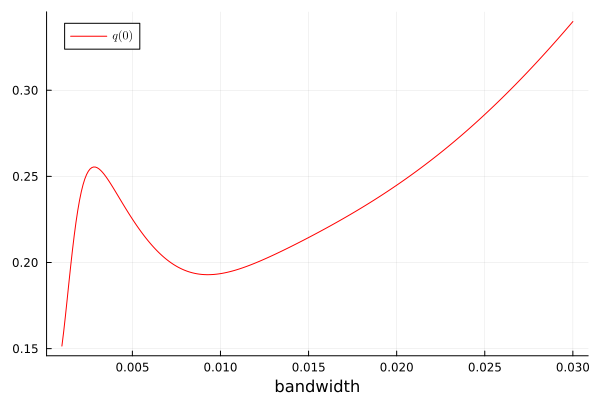

In [12]:
BW, q0 = collect(0.001:0.0001:0.03), []
for bw in BW
    dens = kde(changes,bandwidth=bw)
    append!(q0,(dens.density[Int64(length(dens.density)/2)+1]+dens.density[Int64(length(dens.density)/2)])/2)
end
plot(BW,q0,label=L"q(0)",legend=:topleft,color=:red,xlabel="bandwidth")

----
#### Bootstrapping procedure to see the difference between the pooled kurtosis and the underlying kusrtosis estimated with the first two price changes

<div class="alert alert-block alert-info">
    <b>Replication Note:</b> Unused section in the original program.
</div>


Underlying: 1.26709893671016 (0.040469287564713435)
Pooled: 3.632568148045409 (0.11694723870902089)


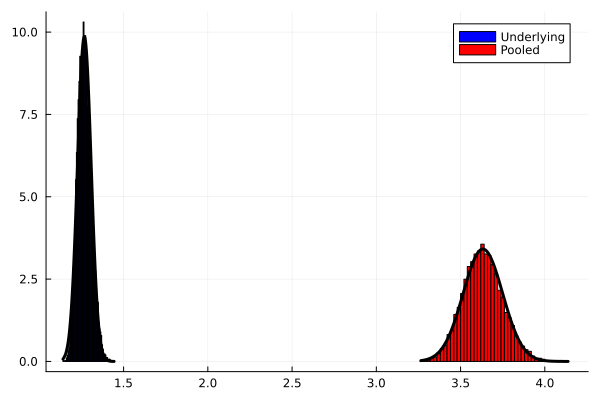

In [13]:
b, B, K, K_pooled = 10000, 15000, [], []
p4, p21, p22 = zeros(b), zeros(b), zeros(b)

for j in 1:1:B
    ind = rand(DiscreteUniform(1,S),b)
    count = 0
    for i in ind
        count += 1
        p21[count] = pow21[i]
        p22[count] = pow22[i]
        p4[count] = pow41[i]
    end
    append!(K, mean(p4)/mean(p22.*p21))
    append!(K_pooled, mean(p4)/mean(p21)^2)
end

m, s = mean(K), std(K)
norm1 = norm_den.(sort!(collect(Set(K))))
print("\nUnderlying: ", m, " (", s, ")\n")
m, s = mean(K_pooled), std(K_pooled)
print("Pooled: ", m, " (", s, ")\n")
norm2 = norm_den.(sort!(collect(Set(K_pooled))))

histogram(K,label="Underlying",legend=:topright,color=:blue,normalize=true)
histogram!(K_pooled,label="Pooled",color=:red,normalize=true)
plot!(sort!(collect(Set(K))),norm1,linewidth=3,color=:black,label="")
plot!(sort!(collect(Set(K_pooled))),norm2,linewidth=3,color=:black,label="")

----
#### Initiate the category database

In [14]:
cat_ids, number = collect(Set(df2.category)), []

for cat in cat_ids
    append!(number, length(collect(Set(df2[df2.category .== cat, :].id))))
end

statistics = DataFrame(category_id = Int64.(cat_ids), number_of_products = Int64.(number))
statistics = statistics[statistics.number_of_products .> 100, :]
statistics.number_price_changes = zeros(Int64,size(statistics,1))
statistics.mean_price_change = zeros(size(statistics,1))
statistics.mean_abs_change = zeros(size(statistics,1))
statistics.mean_inv_change = zeros(size(statistics,1))
statistics.std_price_change = zeros(size(statistics,1))
statistics.skewness = zeros(size(statistics,1))
statistics.alpha_with22 = zeros(size(statistics,1))
statistics.alpha_with22_ste = zeros(size(statistics,1))
statistics.alpha_with31 = zeros(size(statistics,1))
statistics.alpha_with31_ste = zeros(size(statistics,1))
statistics.g11 = zeros(size(statistics,1))
statistics.g11_ste = zeros(size(statistics,1))
statistics.g21 = zeros(size(statistics,1))
statistics.g21_ste = zeros(size(statistics,1))
statistics.g22 = zeros(size(statistics,1)) # 
statistics.g22_ste = zeros(size(statistics,1))
statistics.g31 = zeros(size(statistics,1))
statistics.g31_ste = zeros(size(statistics,1))
statistics.g32 = zeros(size(statistics,1))
statistics.g32_ste = zeros(size(statistics,1))
statistics.M1 = zeros(size(statistics,1))
statistics.M2 = zeros(size(statistics,1))
statistics.M3 = zeros(size(statistics,1))
statistics.M4 = zeros(size(statistics,1))
statistics.underlying12_kurt = zeros(size(statistics,1)) # 
statistics.underlying12_kurt_ste = zeros(size(statistics,1))
statistics.pooled_kurt = zeros(size(statistics,1))
statistics.pooled_kurt_ste = zeros(size(statistics,1))
statistics.corr12 = zeros(size(statistics,1))
statistics.coefvar1 = zeros(size(statistics,1))
statistics.coefvar2 = zeros(size(statistics,1))
statistics.coefvar = zeros(size(statistics,1))
statistics.implied_corr = zeros(size(statistics,1))
statistics.mean_duration = zeros(size(statistics,1))
statistics.ste_duration = zeros(size(statistics,1))
statistics.alpha1 = zeros(size(statistics,1))
statistics.alpha2 = zeros(size(statistics,1))
statistics.ratio_betas = zeros(size(statistics,1))
statistics.weight_on1 = zeros(size(statistics,1))
statistics.C_pooled = zeros(size(statistics,1))
statistics.C = zeros(size(statistics,1));

----
#### Estimate the statistics for the seven biggest categories

<div class="alert alert-block alert-info">
    <b>Replication Note:</b> Number of repetition in the bootstrapping procedure: <br>
    B = 5000 for variable statistics.underlying12_kurt reported as kurtosis (t = 1, 2) in Table 3 <br>
    B = 1000 for variable g22_ste reported as the standard error for Kurtosis pooled <br>
    and variable pooled_kurt_ste reported as the standard error for Kurtosis w/ unobs heterog. in Table 1 <br>    
</div>

<div class="alert alert-block alert-warning">
    <b>Replication Edit:</b> <br> 
    Initialize objects to store and display the empirical results for Table 1, 2, and 3. <br>
    The original program only export the variables for all tables in a single csv file at the end. <br>
    Increase the number of reptition in bootstrapping to 300%
</div>

In [15]:
replicated_t1 = DataFrame(
    cat = Int[], 
    num_prod = Int[], 
    num_p_chg = Int[], 
    Ep = Float64[], 
    sp = Float64[], 
    k_pooled = Float64[], 
    k_pooled_ste = Float64[], 
    k_u = Float64[], 
    k_u_ste = Float64[], 
    C_pooled = Float64[], 
    C_u = Float64[]);

replicated_t2 = DataFrame(
    cat = Int[], 
    g11 = Float64[], 
    g21 = Float64[], 
    g31 = Float64[], 
    g32 = Float64[], 
    a1 = Float64[], 
    a2 = Float64[], 
    bs = Float64[], 
    w = Float64[], 
    a22 = Float64[]);

replicated_t3 = DataFrame(
    cat = Int[], 
    skew = Float64[], 
    kurt = Float64[], 
    kurt_ste = Float64[], 
    kurt12 = Float64[], 
    kurt12_ste = Float64[], 
    corr = Float64[], 
    CV = Float64[]);

In [16]:
statistics = statistics[statistics.number_of_products .> 1000, :]
sort!(statistics,:number_of_products,rev=true)
cat, gammas = 1, zeros(size(statistics,1),5)

for c in statistics.category_id
    dfcat = df2[df2.category .== c, :]
    
    # use the first two price changes to estimate the underlying kurtosis and correlations
    # bootstrap standard errors
    S = size(dfcat[dfcat.initial .== 3, :],1)
    pow41 = (dfcat[dfcat.initial .== 2, :].logchange).^4
    pow42 = (dfcat[dfcat.initial .== 3, :].logchange).^4
    pow21 = (dfcat[dfcat.initial .== 2, :].logchange).^2
    pow22 = (dfcat[dfcat.initial .== 3, :].logchange).^2
    
    # Replication edit: change the number of repetition in bootstrapping
    B, K, K_pooled, p41, p42, p21, p22  = 15000, [], [], zeros(S), zeros(S), zeros(S), zeros(S) 
    for j in 1:1:B
        ind = rand(DiscreteUniform(1,S),S)
        count = 0
        p21, p22, p41, p42 = pow21[ind], pow22[ind], pow41[ind], pow42[ind]
        append!(K, 0.5*mean(p41)/mean(p22.*p21) + 0.5*mean(p42)/mean(p22.*p21))
        append!(K_pooled, mean(vcat(p41,p42))/mean(vcat(p21,p22))^2)
    end
    
    # write the first set of statistics
    i = findfirst(isequal(c),statistics.category_id)
    statistics.number_price_changes[i] = length(dfcat.logchange)
    statistics.mean_price_change[i] = mean(dfcat.logchange)
    statistics.mean_abs_change[i] = mean(abs.(dfcat.logchange))
    statistics.mean_inv_change[i] = mean(abs.(dfcat[dfcat.logchange.>0,:].logchange).^(-1))
    statistics.std_price_change[i] = std(dfcat.logchange)
    statistics.skewness[i] = mean((dfcat.logchange-mean(dfcat.logchange)*ones(length(dfcat.logchange))).^3)/(statistics.std_price_change[i])^3
    statistics.mean_duration[i], statistics.ste_duration[i] = mean(dfcat.duration), std(dfcat.duration)
    statistics.underlying12_kurt[i], statistics.underlying12_kurt_ste[i] = (0.5*mean(pow41)+0.5*mean(pow42))/mean(pow22.*pow21), std(K)
    statistics.corr12[i], statistics.coefvar1[i], statistics.coefvar2[i] = cor(pow21,pow22), std(pow21)/mean(pow21), std(pow22)/mean(pow22)
    
    changes = [dfcat.logchange[abs.(dfcat.logchange).>0.0001]; -dfcat.logchange[abs.(dfcat.logchange).>0.0001]]
    dens = kde(changes)
    # Replication edit: muted printing out density estimates 
    #print(dens.density[Int64(length(dens.density)/2)]," ",dens.x[Int64(length(dens.density)/2)]," ",dens.x[Int64(length(dens.density)/2)+1],"\n")
    statistics.C_pooled[i] = dens.density[Int64(length(dens.density)/2)]/2*var(changes)/mean(abs.(changes))
    
    gamma11, gamma21, gamma22, gamma31, gamma32 = 0, 0, 0, 0, 0
    Sigma31, Sigma22,  = zeros(3,3), zeros(3,3)
    M1, M2, M3, M4, alpha = 0, 0, 0, 0, 0

    # estimate the dimensionless statisticsistics using the algorithm
    ids = collect(Set(dfcat.id))
    cols = vcat(Symbol("product"),[Symbol("e$k") for k in [11, 21, 31, 32, 22]])
    cols = vcat(cols,[Symbol("e$k") for k in [2, 3, 4, 5]])

    # Replication edit: required modification for the for-loop to work
    # Original code returns error: ArgumentError: `DataFrame` constructor with passed eltypes is not supported.
    #dfprod = DataFrame(vcat(Int64, [Float64 for k in 1:9]), cols, length(ids))
    #dfprod.product = ids    
    t = vcat(Int64, [Float64 for k in 1:9])
    dfprod = DataFrame(cols .=> [type[] for type in t])
    for i in ids
        push!(dfprod, (i,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0))
    end
    
    num_correction = []
    for prod in ids
        changes = abs.(dfcat[dfcat.id .== prod, :].logchange[2:end])
        changes = changes[changes.>0]
        p = findfirst(isequal(prod),dfprod.product)
        l = length(changes)
        
        # correction for C
        numerator, Z = mean(changes), (changes.^(-1))*transpose(changes.^2)
        append!(num_correction,(sum(Z) - numerator*l)/l/(l-1))
        
        # gammas
        numerator, summa, k, j = 0, 0, 0, 0
        row = []
        for pair in [11, 21, 31, 32, 22]
            j = Int64(pair%10)
            k = Int64((pair - j)/10)
            numerator, Z = mean(changes.^(j+k)), (changes.^j)*transpose(changes.^k)
            append!(row,(sum(Z) - numerator*l)/l/(l-1))
            append!(row,numerator)
        end
        for col in 1:1:4
            dfprod[p,1+col], dfprod[p,6+col] = row[2*col-1], row[2*col]
        end
        dfprod[p,6] = row[end-1]
    end
    
    # bootstrap standard errors
    mom1, mom2, mom3, mom4 = [], [], [], []
    G11, G21, G22, G31, G32 = [], [], [], [], []
    # Replication edit: change the number of repetition on bootstrapping
    B, C_pooled, C, k_pooled = 3000, [], [], []
    for b in 1:1:B
        indices = rand(DiscreteUniform(1,size(dfprod,1)),Int64(round(size(dfprod,1)*0.8)))
        dfprod_boot = dfprod[indices, :]
        gamma11 = mean(dfprod_boot.e2)/mean(dfprod_boot.e11)
        gamma21 = mean(dfprod_boot.e3)/mean(dfprod_boot.e21)
        gamma31 = mean(dfprod_boot.e4)/mean(dfprod_boot.e31)
        gamma32 = mean(dfprod_boot.e5)/mean(dfprod_boot.e32)
        gamma22 = mean(dfprod_boot.e4)/mean(dfprod_boot.e22)
        append!(G11,gamma11)
        append!(G21,gamma21)
        append!(G31,gamma31)
        append!(G32,gamma32)
        append!(G22,gamma22)
        append!(mom1,1/(gamma11-1))
        append!(mom2,2/(gamma21-1))
        append!(mom3,3/(gamma31-1))
        append!(mom4,3*gamma21/(gamma22*gamma11-gamma21))
        append!(k_pooled,mean(dfprod_boot.e4)/(mean(dfprod_boot.e2))^2)
    end
    
    # estimate the size of Gamma distribution using three different gammas
    # weight myopically with inverse variance, standard errors from Delta method 
    Sigma31[1,1], Sigma31[1,2], Sigma31[1,3] = var(mom1), cov(mom1,mom2), cov(mom1,mom3)
    Sigma31[2,1], Sigma31[2,2], Sigma31[2,3] = Sigma31[1,2], var(mom2), cov(mom2,mom3)
    Sigma31[3,1], Sigma31[3,2], Sigma31[3,3] = Sigma31[1,3], Sigma31[2,3], var(mom3)
    Sigma22[1,1], Sigma22[1,2], Sigma22[1,3] = var(mom1), cov(mom1,mom2), cov(mom1,mom4)
    Sigma22[2,1], Sigma22[2,2], Sigma22[2,3] = Sigma22[1,2], var(mom2), cov(mom2,mom4)
    Sigma22[3,1], Sigma22[3,2], Sigma22[3,3] = Sigma22[1,3], Sigma22[2,3], var(mom4)
    
    weights31, weights22 = ones(3)./[var(mom1), var(mom2), var(mom4)], ones(3)./[var(mom1), var(mom2), var(mom4)]
    weights31, weights22 = weights31/sum(weights31), weights22/sum(weights22)

    gamma11 = mean(dfprod.e2)/mean(dfprod.e11)
    gamma21 = mean(dfprod.e3)/mean(dfprod.e21)
    gamma31 = mean(dfprod.e4)/mean(dfprod.e31)
    gamma32 = mean(dfprod.e5)/mean(dfprod.e32)
    gamma22 = mean(dfprod.e4)/mean(dfprod.e22) # this is the underlying Kurtosis
    M1, M2, M3, M4 = 1/(gamma11-1), 2/(gamma21-1), 3/(gamma31-1), 3*gamma21/(gamma22*gamma11-gamma21)
    alpha_with31, alpha_with22 = [M1 M2 M3]*weights31, [M1 M2 M4]*weights22
    alpha_with31, alpha_with22 = alpha_with31[1], alpha_with22[1]
    
    # write the rest of the statisticsistics
    statistics.alpha_with31[i], statistics.alpha_with31_ste[i] = alpha_with31, sqrt((weights22')*Sigma31*weights22)
    statistics.alpha_with22[i], statistics.alpha_with22_ste[i] = alpha_with22, sqrt((weights31')*Sigma22*weights31)
    statistics.g11[i], statistics.g11_ste[i] = gamma11, std(G11)
    statistics.g21[i], statistics.g21_ste[i] = gamma21, std(G21)
    statistics.g22[i], statistics.g22_ste[i] = gamma22, std(G22)
    statistics.g31[i], statistics.g31_ste[i] = gamma31, std(G31)
    statistics.g32[i], statistics.g32_ste[i] = gamma32, std(G32)
    statistics.M1[i], statistics.M2[i], statistics.M3[i], statistics.M4[i] = M1, M2, M3, M4
    statistics.pooled_kurt[i], statistics.pooled_kurt_ste[i] = mean(dfprod.e4)/((mean(dfprod.e2))^2), std(k_pooled)
    statistics.coefvar[i] = sqrt(mean(dfprod.e4)-(mean(dfprod.e2))^2)/mean((dfprod.e2))
    statistics.implied_corr[i] = (statistics.pooled_kurt[i]/statistics.g22[i] - 1)/(statistics.coefvar[i]^2)
    statistics.C[i] = statistics.C_pooled[i]*mean(num_correction)/(statistics.mean_inv_change[i]*statistics.std_price_change[i]^2)
    
    gammas[cat,1], gammas[cat,2:end] = i, [gamma11, gamma21, gamma22, gamma32]
    cat += 1
    
    # Replication edit: muted printing out category size
    #print(" category number ",(" "*string(c))[end-3:end]," of the size ",length(ids),"\n")

    # Replication edit: store (some) empirical results for display
    push!(
        replicated_t1, 
        [c, 
            length(ids), 
            statistics.number_price_changes[i], 
            round(statistics.mean_price_change[i],digits = 3), 
            round(statistics.std_price_change[i], digits = 2), 
            round(statistics.pooled_kurt[i], digits = 1), 
            round(statistics.pooled_kurt_ste[i], digits = 2), 
            round(statistics.g22[i],digits = 1), 
            round(statistics.g22_ste[i], digits = 2), 
            round(statistics.C_pooled[i], digits = 2), 
            round(statistics.C[i], digits = 2)])

    push!(
        replicated_t2, 
        [c, 
            round(statistics.g11[i], digits = 3), 
            round(statistics.g21[i], digits = 3), 
            round(statistics.g31[i], digits = 3), 
            round(statistics.g32[i], digits = 3), 
            round(statistics.alpha1[i], digits = 3), 
            round(statistics.alpha2[i], digits = 3), 
            round(statistics.ratio_betas[i], digits = 3), 
            round(statistics.weight_on1[i], digits = 3), 
            round(statistics.alpha_with22[i], digits = 3)
            ])
    
    push!(
        replicated_t3, 
        [c, 
            round(statistics.skewness[i], digits = 3), 
            round(statistics.g22[i], digits = 3), 
            round(statistics.g22_ste[i], digits = 3), 
            round(statistics.underlying12_kurt[i], digits = 3), 
            round(statistics.underlying12_kurt_ste[i], digits = 3), 
            round(statistics.implied_corr[i], digits = 3), 
            round(statistics.coefvar[i], digits = 3)
            ])
end

----
#### Implement distance minimization for all categories, fit parameters of:
- two Gamma distributions
- $\alpha_1$ and $\alpha_2$
- the weight on the first one
- the ratio of $\beta_1$ and $\beta_2$ are identified

In [17]:
for cat in 1:1:7 
    res = optimize(x->gap(x,gammas[cat,2:end]), [0.1, 0.1, 10.0, 0.0], autodiff=:forward)
    i = Int64(gammas[cat,1])
    print("\n",abs.(res.minimizer)," ",res.minimum,"\n")
    statistics.alpha1[i] = abs(res.minimizer[1])
    statistics.alpha2[i] = abs(res.minimizer[2])
    statistics.ratio_betas[i] = abs(res.minimizer[3])
    statistics.weight_on1[i] = abs(res.minimizer[4])
end

[2.09942163427602, 12.189705096368385, 228.67664052180163, 0.16103548867504724] 0.006755224324577664

[1.058372110851099, 6.021216033602336, 91.43923776507174, 0.10918389354465582] 0.0023290634835912987

[0.5985547090538865, 3.872609716558922, 73.41398353172926, 2.516990004059588e-8] 0.013485310293358818

[1.8480701506050723, 9.778922321705824, 173.04754076503505, 0.13125048581635704] 0.0022793394382188007

[3.1225661350000826, 9.836302734609887, 0.627976223929819, 0.5801483724888479] 8.98489445162344e-5

[0.9666290005120862, 5.441559950442631, 84.15392503709913, 0.08923899699779639] 0.0010276647206832322

[0.9977876340711986, 5.783151643883908, 103.46998523030001, 0.031228361591337454] 0.0005743840987871349


----
#### Create an array of price changes for these categories
Price changes in units of respective standard deviations

In [18]:
standardized_changes = zeros(1)
raw_changes = zeros(1)
mean_duration = 0

for c in statistics.category_id
    dfcat = df2[df2.category .== c, :]
    standardized_changes = vcat(standardized_changes,dfcat[dfcat.logchange.!=0,:logchange]/std(dfcat[dfcat.logchange.!=0,:logchange]))
    raw_changes = vcat(raw_changes,dfcat[dfcat.logchange.!=0,:logchange])
    mean_duration += sum(dfcat.duration)
end

mean_duration = mean_duration/length(raw_changes)
N_pooled = 365/mean_duration
V_raw = var(raw_changes[2:end])
V_sta = var(standardized_changes[2:end])
print(N_pooled," ",V_raw," ",V_sta)

10.777421896857614 0.10605110503016536 1.0000102251389038

----
<div class="alert alert-block alert-warning">
    <b>Replication Edit:</b> Entered the reported values in the tables included in the published article. Compare with the values generated by the program.
</div>

Include the empirical estimates for Table 2

In [19]:
replicated_t2[!,6] .= round.(statistics.alpha1, digits = 3);
replicated_t2[!,7] .= round.(statistics.alpha2, digits = 3);
replicated_t2[!,8] .= round.(statistics.ratio_betas, digits = 3);
replicated_t2[!,9] .= round.(statistics.weight_on1, digits = 3);

Print Tables

In [20]:
println(replicated_t1) # Table 1
println(replicated_t2) # Table 2
println(replicated_t3) # Table 3

7×11 DataFrame
 Row │ cat    num_prod  num_p_chg  Ep       sp       k_pooled  k_pooled_ste  k_u      k_u_ste  C_pooled  C_u
     │ Int64  Int64     Int64      Float64  Float64  Float64   Float64       Float64  Float64  Float64   Float64
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │   111      3439      75144    0.002     0.34       3.4          0.16      1.7     0.07      0.07     0.06
   2 │   119      3228      56898    0.002     0.33       3.8          0.1       2.0     0.05      0.1      0.07
   3 │  1212      2551      30361   -0.001     0.25       3.5          0.27      2.1     0.16      0.07     0.06
   4 │   122      1405      27563    0.002     0.34       3.0          0.09      1.7     0.05      0.1      0.07
   5 │   118      1390      30492    0.003     0.31       3.6          0.24      2.0     0.12      0.06     0.06
   6 │   117      1154      21123    0.007     0.31       3.5          0.14      2.0

Calculate the differene in the replicated estimates and the reported value in the paper

In [21]:
reported_t1 = DataFrame(
    cat = [111,119,1212,122,118,117,561], 
    num_prod = [3439, 3228, 2551, 1405, 1390, 1154, 1032], 
    num_p_chg = [75144, 56898, 30361, 27563, 30492, 21123, 17782], 
    Ep = [0.002, 0.002, -0.001, 0.002, 0.003, 0.007, 0.002], 
    sp = [0.34, 0.33, 0.25, 0.34, 0.31, 0.31, 0.26], 
    k_pooled = [3.4, 3.8, 3.5, 3.0, 3.6, 3.5, 3.3], 
    k_pooled_ste = [0.16, 0.09, 0.27, 0.09, 0.24, 0.14, 0.22], 
    k_u = [1.7, 2.0, 2.1, 1.7, 2.0, 2.0, 1.8], 
    k_u_ste = [0.07, 0.05, 0.16, 0.05, 0.12, 0.05, 0.13], 
    C_pooled = [0.07, 0.10, 0.07, 0.10, 0.06, 0.08, 0.05], 
    C_u = [0.06, 0.07, 0.06, 0.07, 0.06, 0.06, 0.04])

reported_t2 = DataFrame(
    cat = [111,119,1212,122,118,117,561], 
    g11 = [1.248, 1.282, 1.242, 1.243, 1.289, 1.281, 1.216],
    g21 = [1.406, 1.507, 1.476, 1.397, 1.539, 1.511, 1.394],
    g31 = [1.507, 1.702, 1.786, 1.508, 1.777, 1.721, 1.586],
    g32 = [1.787, 2.381, 2.923, 1.903, 2.552, 2.484, 2.271],
    a1 = [2.099, 1.058, 0.599, 1.848, 3.123, 0.967, 0.998],
    a2 = [12.19, 6.012, 3.873, 9.779, 9.836, 5.442, 5.783],
    bs = [228.677, 91.439, 73.414, 173.048, 0.628, 84.154, 103.470],
    w = [0.161,0.109,0.000,0.131,0.580,0.089,0.031],
    a22 = [4.248, 3.747, 4.151, 4.460, 3.610, 3.801, 4.782])

reported_t3 = DataFrame(
    cat = [111,119,1212,122,118,117,561], 
    skew = [-0.121,0.011,-0.020,-0.025,-0.012,-0.004,-0.006],
    kurt = [1.656, 1.955, 2.051, 1.677, 2.044, 1.989, 1.778],
    kurt_ste = [0.065, 0.050, 0.162, 0.051, 0.118, 0.047, 0.133],
    kurt12 = [1.426, 1.288, 1.710, 1.189, 1.663, 1.422, 1.403],
    kurt12_ste = [0.071, 0.042, 0.186, 0.019, 0.150, 0.089, 0.066],
    corr = [0.440, 0.339, 0.284, 0.390, 0.295, 0.303, 0.374],
    CV = [1.555, 1.683, 1.589, 1.398, 1.620, 1.577, 1.524])

diff_t1 = reported_t1 .- replicated_t1
diff_t1[:, :cat] = reported_t1[:,1]

diff_t2 = reported_t2 .- replicated_t2
diff_t2[:, :cat] = reported_t2[:,1]

diff_t3 = reported_t3 .- replicated_t3
diff_t3[:, :cat] = reported_t3[:,1]

println(diff_t1)
println(diff_t2)
println(diff_t3)

7×11 DataFrame
 Row │ cat    num_prod  num_p_chg  Ep       sp       k_pooled  k_pooled_ste  k_u      k_u_ste  C_pooled  C_u
     │ Int64  Int64     Int64      Float64  Float64  Float64   Float64       Float64  Float64  Float64   Float64
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │   111         0          0      0.0      0.0       0.0          0.0       0.0      0.0       0.0      0.0
   2 │   119         0          0      0.0      0.0       0.0         -0.01      0.0      0.0       0.0      0.0
   3 │  1212         0          0      0.0      0.0       0.0          0.0       0.0      0.0       0.0      0.0
   4 │   122         0          0      0.0      0.0       0.0          0.0       0.0      0.0       0.0      0.0
   5 │   118         0          0      0.0      0.0       0.0          0.0       0.0      0.0       0.0      0.0
   6 │   117         0          0      0.0      0.0       0.0          0.0       0.0

----
#### Plot the histogram and fitted density of non-standardized changes

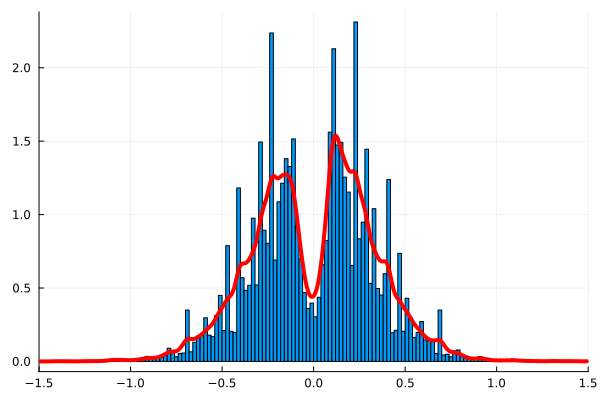

In [22]:
density = kde(raw_changes,bandwidth=0.035,kernel=Logistic)
histogram(raw_changes,xlim=[-1.5,1.5],normed=true,bins=200,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

----
#### Plot the histogram and fitted symmetrized density of non-standardized changes

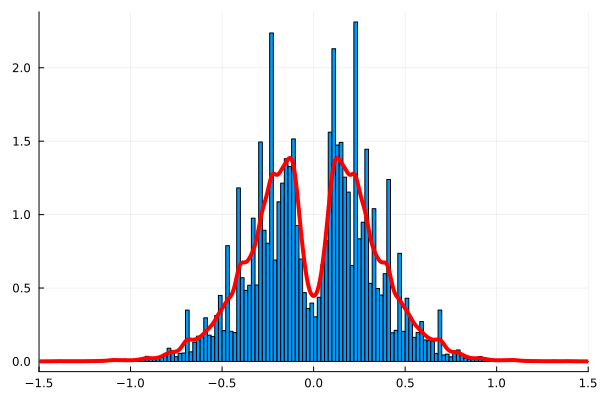

In [23]:
raw_changes_sym = vcat(-raw_changes[2:end],raw_changes[2:end])
density = kde(raw_changes_sym,bandwidth=0.035,kernel=Logistic)
histogram(raw_changes,xlim=[-1.5,1.5],normed=true,bins=200,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

----
#### Plot the symmetrized histogram and fitted symmetrized density of non-standardized changes

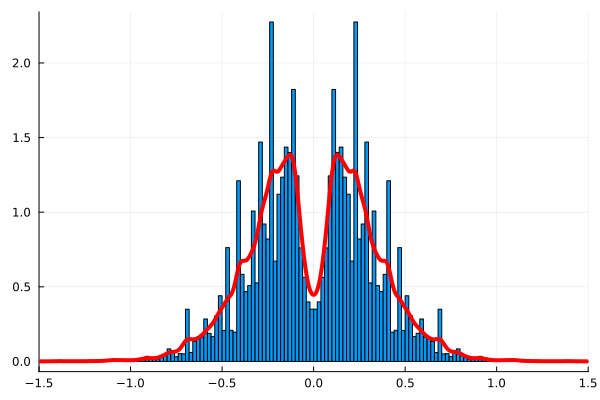

In [24]:
kernel_den_raw = DataFrame(x = density.x, q = density.density)
CSV.write("kernel_den_raw.csv",kernel_den_raw)
histogram(raw_changes_sym,xlim=[-1.5,1.5],normed=true,bins=200,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

----
#### Plot the histogram and fitted density of standardized changes

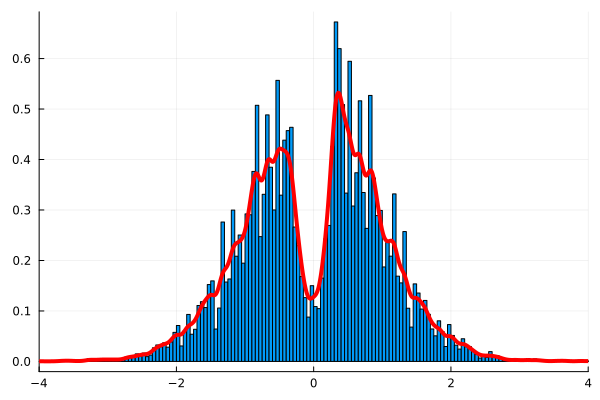

In [25]:
density = kde(standardized_changes,bandwidth=0.08,kernel=Logistic)
kernel_den_raw = DataFrame(x = density.x, q = density.density)
histogram(standardized_changes,xlim=[-4,4],normed=true,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

----
#### Plot the histogram and fitted symmetrized density of standardized changes

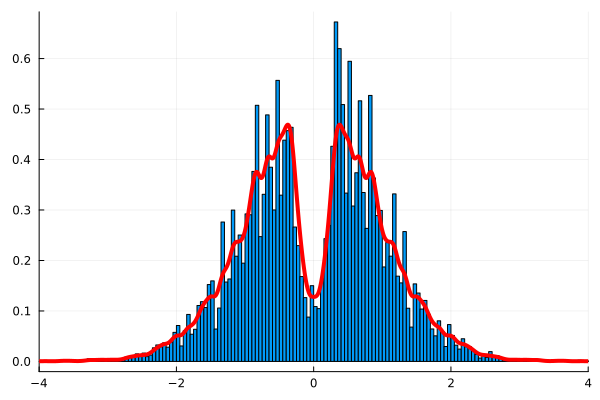

In [26]:
standardized_changes_sym = vcat(-standardized_changes[2:end],standardized_changes[2:end])
density = kde(standardized_changes_sym,bandwidth=0.08,kernel=Logistic)
histogram(standardized_changes,xlim=[-4,4],normed=true,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

----
#### Plot the symmetrized histogram and fitted symmetrized density of standardized changes

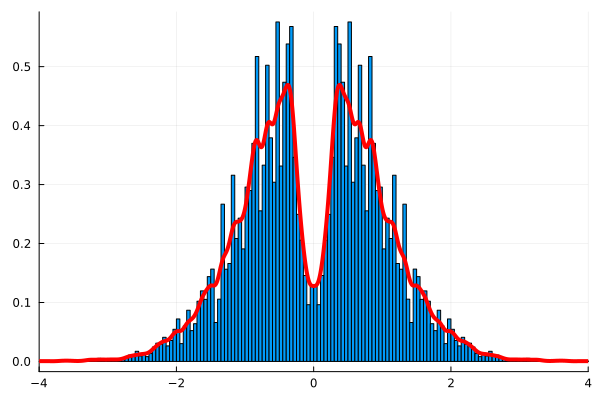

In [27]:
kernel_den_sta = DataFrame(x = density.x, q = density.density)
CSV.write("kernel_den_sta.csv",kernel_den_sta)
histogram(standardized_changes_sym,xlim=[-4,4],normed=true,legend=false)
plot!(density.x,density.density,color=:red,linewidth=4)

----
#### Produce the table with the statistics
Part of this table is table 1 in the paper
Another part goes to the apendix

In [28]:
stat_string = DataFrame(category_id = Int64.(statistics.category_id))
for name in names(statistics)
    stat_string[!,name] = map(x->string(round(x;digits=3)),statistics[:,name])
end
stat_string[!, :number_price_changes] = Int64.(round.(statistics[!, :number_price_changes]))
stat_string[!, :number_of_products] = Int64.(round.(statistics[!, :number_of_products]))
stat_string[!, :category_id] = Int64.(round.(statistics[!, :category_id]))
CSV.write("categories_big_table.csv",stat_string);